<a href="https://colab.research.google.com/github/basmaeldrandaly/ML-code/blob/main/knapsack.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

the genome

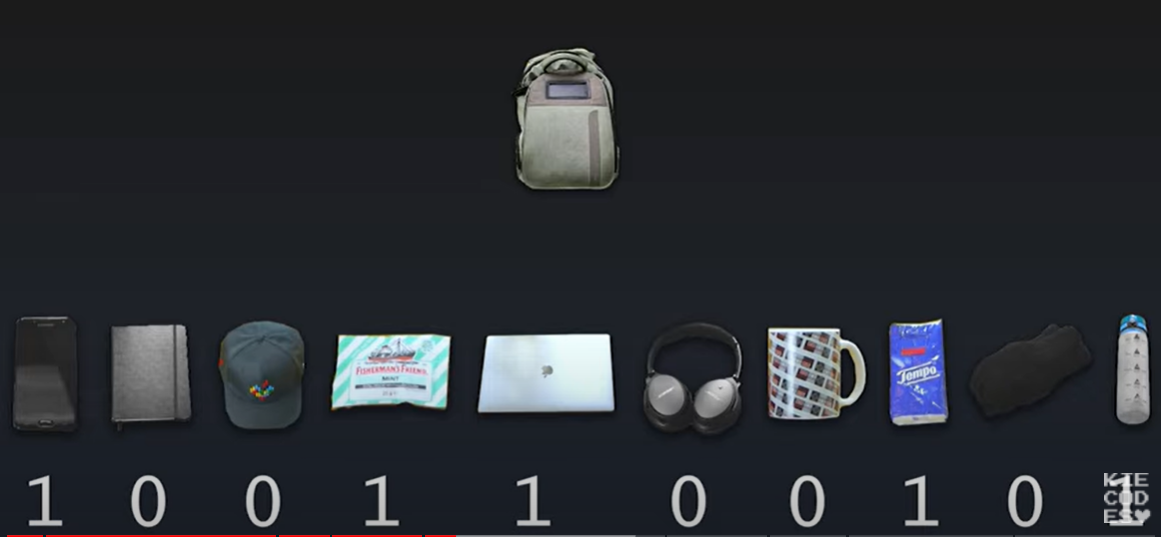

the population of multiple solutions

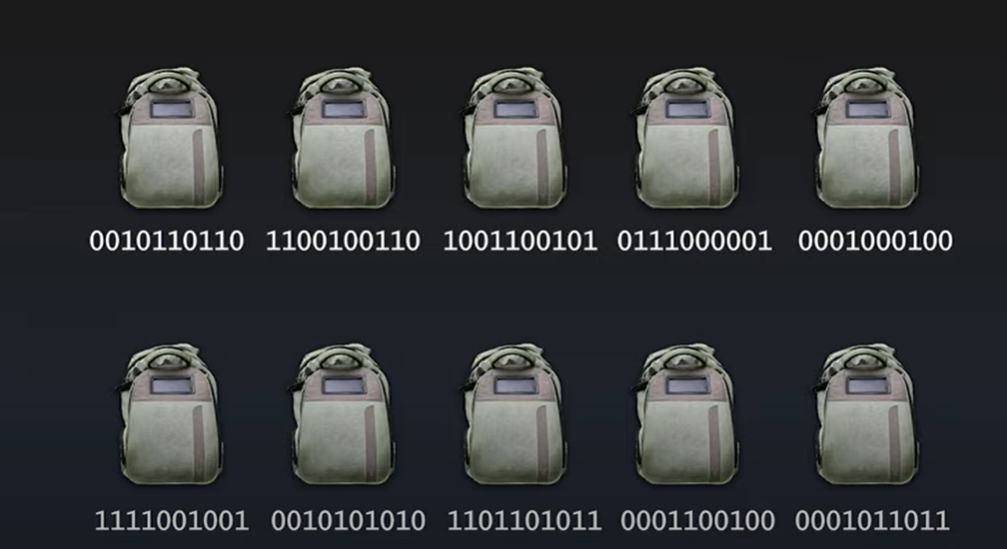

In [25]:
from typing import List, Callable, Tuple
from collections import namedtuple
from functools import partial
from random import choices, randint, randrange
import random

List of zeros and ones representing what items we included and what items we didn't include

In [27]:
Genome= List[int]

In [3]:
population= List[Genome]

In [4]:
FitnessFunc=Callable[[Genome],int]

In [5]:
PopulateFunc = Callable[[], population]

In [6]:
SelectionFunc = Callable[[population, FitnessFunc], Tuple[Genome, Genome]]

In [7]:
CrossoverFunc = Callable[[Genome, Genome], Tuple[Genome, Genome]]

In [28]:
MutationFunc = Callable[[Genome], Genome]

In [9]:
Thing=namedtuple('Thing',['name','value','weight'])

In [10]:
PrinterFunc = Callable[[population, int, FitnessFunc], None]

List of things we have to choose from

In [29]:
things = [
    Thing('Laptop', 500, 2200),
    Thing('Headphones', 150, 160),
    Thing('Coffee Mug', 60, 350),
    Thing('Notepad', 40, 333),
    Thing('Water Bottle', 30, 192),
]

more_things = [
    Thing('Mints', 5, 25),
    Thing('Socks', 10, 38),
    Thing('Tissues', 15, 80),
    Thing('Phone', 500, 200),
    Thing('Baseball Cap', 100, 70)
] + things


function that returns a genome (list of zeros and ones of length k)

In [30]:
def generate_genome(length: int) -> Genome:
    return choices([0, 1], k=length)

function that returns population by calling generate genome for multiple times(size of population)

In [31]:
def generate_population(size: int, genome_length: int) -> population:
  return[generate_genome(genome_length) for _ in range(size)]

function that evaluates the fitness of each genome (its weight and value)

In [32]:
def fitness(genome: Genome, things: [Thing], weight_limit: int) -> int:
  if len(genome)!= len(things):
    raise ValueError("genome and things must be of the same size")

  weight=0
  value=0

  for i, thing in enumerate(things):
    #check if the genome contains an item
    if genome[i]==1:
      #then add its weight & value
      weight+=thing.weight
      value+=thing.value
      #if the weights of items in that genome exceeds the limit weight, return 0 (not possible to choose this genome/sol)
      if weight>weight_limit:
         return 0
#as the value is what matters (as long as the weight is within the range)
  return value

select function to select pair of solutions which will be the parents of the next generation

In [33]:
#uses python choices function to choose randomly the most valuable pairs (according to their possibility =weights/vlaues, k=2 as it returns 2 parents)
def selection_pair(population:population, fitness_func:FitnessFunc) -> population:
  return choices(
      population=population,
      weights=[fitness_func(genome) for genome in population],
      k=2
  )

the cross over function takes 2 parents(the selected ones) and returns 2 children

In [34]:
def single_point_crossover(a: Genome, b: Genome) -> Tuple[Genome, Genome]:
    if len(a) != len(b):
        raise ValueError("Genomes a and b must be of same length")
#length must be at least 2
    length = len(a)
    if length < 2:
        return a, b
#choose the point randomly
    p = randint(1, length - 1)
    return a[0:p] + b[p:], b[0:p] + a[p:]

the mutation function takes the genome to be mutated, the mutation probability, it changes 1 to zero, and zero to 1

In [35]:
def mutation(genome: Genome, num: int = 1, probability: float = 0.5) -> Genome:
    for _ in range(num):
      #generate rand number within the length of the genome (to specify what index within the genome to mutate)
        index = randrange(len(genome))
        #generate another rand, and if that random number is bigger than the mutation probability, then no mutation, else mutate that index
        genome[index] = genome[index] if random() > probability else abs(genome[index] - 1)
    return genome

function that combines all of the above

In [36]:
def run_evolution(
        populate_func: PopulateFunc,
        fitness_func: FitnessFunc,
        #stopping condition
        fitness_limit: int,
        selection_func: SelectionFunc = selection_pair,
        crossover_func: CrossoverFunc = single_point_crossover,
        mutation_func: MutationFunc = mutation,
        #the max number of generations to run(if we're not reavhing the fitness limit)
        generation_limit: int = 100,
       ) \
        -> Tuple[population, int]:
        #get the first generation
    population = populate_func()

#loop for generation limit
    for i in range(generation_limit):
      #sort the population by fitness
        population = sorted(population, key=lambda genome: fitness_func(genome), reverse=True)
#if the top fitness we reached is bigger than the fitness limit then STOP
        if fitness_func(population[0]) >= fitness_limit:
            break
#eliticism ( keeps best 2 genomes to the next generation)
        next_generation = population[0:2]

#generate all other new solutions for our next generation
#pick 2 parents and get 2 new solutions every time, so we loop for half the length of a generation to get the same number of solutions in our next generation as before
#-1 because we already copied the top 2 solutions from the last generation , so we saved one iteration already 
        for j in range(int(len(population) / 2) - 1):
            parents = selection_func(population, fitness_func)
            offspring_a, offspring_b = crossover_func(parents[0], parents[1])
            offspring_a = mutation_func(offspring_a)
            offspring_b = mutation_func(offspring_b)
            next_generation += [offspring_a, offspring_b]
#after we're done we replace the current population with the new generation
        population = next_generation
#return the final populations, and the number of generation we're in
    return population, i

In [37]:
population, generations= run_evolution(
    populate_func=partial(
         generate_population, size=10, genome_length=len(more_things)
    ),
    fitness_func=partial(
    fitness, things=more_things, weight_limit=3000
), 
#if the fitness of the best solution exceeds this limit then we're done
fitness_limit=1310,
generation_limit=100
)

In [38]:
print(f"number of generations: {generations}")

number of generations: 0


write the names of items that were included in our genome solution

In [39]:
def genome_to_things(genome: Genome, things:[Thing]) ->[Thing]:
  result=[]
  for i, thing in enumerate(things):
    if genome[i]==1:
      result+=[thing.name]

  return result

pass the top solution

In [40]:
print(f"best solution:{genome_to_things(population[0], more_things)}")

best solution:['Mints', 'Socks', 'Tissues', 'Phone', 'Baseball Cap', 'Laptop', 'Headphones', 'Water Bottle']
